# single-label vs multi-label

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from plantclef.spark import get_spark

spark = get_spark()
display(spark)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/03/07 09:17:20 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/03/07 09:17:20 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).


In [3]:
import os
from pathlib import Path

# Get list of stored filed in cloud bucket
root = Path(os.path.expanduser("~"))
! date

Fri Mar  7 09:17:23 AM EST 2025


In [4]:
# Path and dataset names
data_path = f"{root}/p-dsgt_clef2025-0/shared/plantclef/data/parquet/"

# Define the path to the train and test parquet files
train_path = f"{data_path}/train"
test_path = f"{data_path}/test"

# Read the parquet files into a spark DataFrame
train_df = spark.read.parquet(train_path)
test_df = spark.read.parquet(test_path)

# Show the data
train_df.show(n=5)
test_df.show(n=5)

+--------------------+--------------------+--------------------+-----+----------+----------+--------------------+-------+----------------+--------+-----------------+------------------+---------------+--------------------+-------------+----------+--------+-----------+--------------------+--------------------+---------+--------------------+
|          image_name|                path|                data|organ|species_id|    obs_id|             license|partner|          author|altitude|         latitude|         longitude|gbif_species_id|             species|        genus|    family| dataset|  publisher|          references|                 url|learn_tag|    image_backup_url|
+--------------------+--------------------+--------------------+-----+----------+----------+--------------------+-------+----------------+--------+-----------------+------------------+---------------+--------------------+-------------+----------+--------+-----------+--------------------+--------------------+---------

+--------------------+--------------------+--------------------+
|          image_name|                path|                data|
+--------------------+--------------------+--------------------+
|CBN-Pla-B3-201907...|/test/data/PlantC...|[FF D8 FF E0 00 1...|
|CBN-PdlC-E5-20180...|/test/data/PlantC...|[FF D8 FF E0 00 1...|
|CBN-PdlC-B1-20140...|/test/data/PlantC...|[FF D8 FF E0 00 1...|
|CBN-Pla-D4-201507...|/test/data/PlantC...|[FF D8 FF E0 00 1...|
|CBN-PdlC-F3-20190...|/test/data/PlantC...|[FF D8 FF E0 00 1...|
+--------------------+--------------------+--------------------+
only showing top 5 rows



In [8]:
import matplotlib.pyplot as plt
from plantclef.serde import deserialize_image
from pyspark.sql import functions as F

# filter test dataframe
test_image = "CBN-Pyr-03-20230706.jpg"
test_df = test_df.where(F.col("image_name") == test_image).cache()
test_df.show()

+--------------------+--------------------+--------------------+
|          image_name|                path|                data|
+--------------------+--------------------+--------------------+
|CBN-Pyr-03-202307...|/test/data/PlantC...|[FF D8 FF DB 00 4...|
+--------------------+--------------------+--------------------+



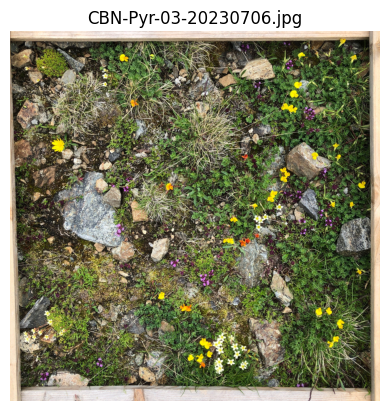

In [15]:
test_image_data = test_df.select("data").collect()[0][0]
original_image = deserialize_image(test_image_data)

plt.imshow(original_image)
plt.title(test_image)
plt.axis("off")
plt.show()